In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
import optuna
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import TargetEncoder
from sklearn.metrics import roc_curve

In [2]:
def read_data(path_to_file: str) -> pd.DataFrame:
    data = pd.read_csv(path_to_file, parse_dates=[2])
    data = data.rename(columns={'sensor1': 'displacements_x',
                                'sensor2': 'displacements_y',
                                'time_x': 'time',
                                'speedSet': 'angular_velocity'})
    data = data[['time', 'displacements_x', 'displacements_y', 'angular_velocity', 'load_value', 'gear_fault_desc']]
    return data

In [3]:
def read_data_and_choose(path_to_file: str, velocity: float, load: bool) -> pd.DataFrame:
    data = pd.read_csv(path_to_file, parse_dates=[2])
    data = data.rename(columns={'sensor1': 'displacements_x',
                                'sensor2': 'displacements_y',
                                'time_x': 'time',
                                'speedSet': 'angular_velocity'})
    duration = np.array([round((0.0002 * i), 4) for i in range(data.shape[0])])
    data['time'] = duration
    data['displacements'] = np.sqrt(data['displacements_x']**2 + data['displacements_y']**2)
    data = data[['time', 'displacements_x', 'displacements_y', 'displacements' ,'angular_velocity', 'load_value', 'gear_fault_desc']]
    if load:
        load_value = 80
    else:
        load_value = 0
    data = data[(data['angular_velocity'] == velocity) & (data['load_value'] == load_value)]
    data['time'] = data['time'] - data['time'].iloc[0]
    return data

In [4]:
def do_rfft_features(data: pd.DataFrame) -> pd.DataFrame:
    y = data['defect']
    X = data.drop(columns=['defect']).values
    X = np.abs(np.fft.rfft(X, axis=1)) / X.shape[1] 
    data = pd.DataFrame(X, y).reset_index().rename(columns={'index': 'defect'})
    return data

In [5]:
def get_features_and_target(velocity: float, load: bool, n_cols: int) -> pd.DataFrame:
    data_eccentricity = read_data_and_choose('eccentricity.csv', velocity, load)
    data_missing_tooth = read_data_and_choose('missing_tooth.csv', velocity, load)
    data_no_fault = read_data_and_choose('no_fault.csv', velocity, load)
    data_root_crack = read_data_and_choose('root_crack.csv', velocity, load)
    data_surface_fault = read_data_and_choose('surface_fault.csv', velocity, load)
    data_tooth_chipped_fault = read_data_and_choose('tooth_chipped_fault.csv', velocity, load)
    
    n_rows = 25000 // n_cols
    remain = 25000 % n_cols
    if remain == 0:
        
        X_1 = data_eccentricity['displacements'].values.reshape(n_rows, n_cols)
        y_1 = np.array(['eccentricity' for _ in range(n_rows)])

        X_2 = data_missing_tooth['displacements'].values.reshape(n_rows, n_cols)
        y_2 = np.array(['missing_tooth' for _ in range(n_rows)])

        X_3 = data_no_fault['displacements'].values.reshape(n_rows, n_cols)
        y_3 = np.array(['no_fault' for _ in range(n_rows)])

        X_4 = data_root_crack['displacements'].values.reshape(n_rows, n_cols)
        y_4 = np.array(['root_crack' for _ in range(n_rows)])

        X_5 = data_surface_fault['displacements'].values.reshape(n_rows, n_cols)
        y_5 = np.array(['surface_fault' for _ in range(n_rows)])

        X_6 = data_tooth_chipped_fault['displacements'].values.reshape(n_rows, n_cols)
        y_6 = np.array(['tooth_chipped_fault' for _ in range(n_rows)])

        X = np.vstack((X_1, X_2, X_3, X_4, X_5, X_6))
        y = np.concatenate((y_1, y_2, y_3, y_4, y_5, y_6))
        data = pd.DataFrame(X, y).reset_index().rename(columns={'index': 'defect'})
        return data
    
    else:
        
        X_1 = data_eccentricity['displacements'].values[: -(25000 % n_cols)].reshape(n_rows, n_cols)
        y_1 = np.array(['eccentricity' for _ in range(n_rows)])

        X_2 = data_missing_tooth['displacements'].values[: -(25000 % n_cols)].reshape(n_rows, n_cols)
        y_2 = np.array(['missing_tooth' for _ in range(n_rows)])

        X_3 = data_no_fault['displacements'].values[: -(25000 % n_cols)].reshape(n_rows, n_cols)
        y_3 = np.array(['no_fault' for _ in range(n_rows)])

        X_4 = data_root_crack['displacements'].values[: -(25000 % n_cols)].reshape(n_rows, n_cols)
        y_4 = np.array(['root_crack' for _ in range(n_rows)])

        X_5 = data_surface_fault['displacements'].values[: -(25000 % n_cols)].reshape(n_rows, n_cols)
        y_5 = np.array(['surface_fault' for _ in range(n_rows)])

        X_6 = data_tooth_chipped_fault['displacements'][: -(25000 % n_cols)].values.reshape(n_rows, n_cols)
        y_6 = np.array(['tooth_chipped_fault' for _ in range(n_rows)])

        X = np.vstack((X_1, X_2, X_3, X_4, X_5, X_6))
        y = np.concatenate((y_1, y_2, y_3, y_4, y_5, y_6))
        data = pd.DataFrame(X, y).reset_index().rename(columns={'index': 'defect'})
        return data

In [6]:
def get_all_features_and_targets(n_cols: int, do_fft: bool) -> pd.DataFrame:
    data_1 = get_features_and_target(velocity=8.33203125, load=False, n_cols=n_cols)
    if do_fft:
        data_1 = do_rfft_features(data_1)
    data_1['velocity'] = 8.33203125
    data_1['load'] = 0.0
    data_2 = get_features_and_target(velocity=8.33203125, load=True, n_cols=n_cols)
    if do_fft:
        data_2 = do_rfft_features(data_2)
    data_2['velocity'] = 8.33203125
    data_2['load'] = 80.0
    data_3 = get_features_and_target(velocity=25.0, load=False, n_cols=n_cols)
    if do_fft:
        data_3 = do_rfft_features(data_3)
    data_3['velocity'] = 25.0
    data_3['load'] = 0.0
    data_4 = get_features_and_target(velocity=25.0, load=True, n_cols=n_cols)
    if do_fft:
        data_4 = do_rfft_features(data_4)
    data_4['velocity'] = 25.0
    data_4['load'] = 80.0
    data_5 = get_features_and_target(velocity=40.0, load=False, n_cols=n_cols)
    if do_fft:
        data_5 = do_rfft_features(data_5)
    data_5['velocity'] = 40.0
    data_5['load'] = 0.0
    data_6 = get_features_and_target(velocity=40.0, load=True, n_cols=n_cols)
    if do_fft:
        data_6 = do_rfft_features(data_6)
    data_6['velocity'] = 40.0
    data_6['load'] = 80.0
    data = pd.concat([data_1, data_2, data_3, data_4, data_5, data_6], axis=0)
    data = data.reset_index().drop(columns='index', axis=1)
    data = data.rename(str, axis="columns") 
    return data

In [7]:
df = get_all_features_and_targets(n_cols=150, do_fft=False)
df

,defect,0,1,2,3,4,5,6,7,8,...,142,143,144,145,146,147,148,149,velocity,load
0,eccentricity,3.503794,3.504284,3.501296,3.502646,3.502895,3.504385,3.501738,3.501451,3.502886,...,3.502059,3.502401,3.502008,3.502532,3.502168,3.503452,3.502139,3.503672,8.332031,0.0
1,eccentricity,3.502760,3.501581,3.502624,3.502988,3.502616,3.503119,3.502050,3.502033,3.501911,...,3.505095,3.502054,3.502726,3.504403,3.503815,3.503268,3.502291,3.504622,8.332031,0.0
2,eccentricity,3.503811,3.504516,3.502063,3.503334,3.504596,3.505016,3.503701,3.502291,3.503794,...,3.503545,3.502848,3.503642,3.503317,3.501953,3.502046,3.503060,3.502029,8.332031,0.0
3,eccentricity,3.504140,3.501932,3.502958,3.501358,3.500961,3.503009,3.502646,3.499939,3.502037,...,3.503828,3.502882,3.502886,3.503351,3.503136,3.501852,3.502624,3.503815,8.332031,0.0
4,eccentricity,3.502794,3.503614,3.502059,3.502536,3.503579,3.504297,3.503097,3.501358,3.503313,...,3.502295,3.500526,3.504702,3.503330,3.503921,3.501852,3.503500,3.502620,8.332031,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5971,tooth_chipped_fault,3.521564,3.467792,3.529033,3.476408,3.491611,3.510696,3.500587,3.520705,3.507101,...,3.526941,3.489998,3.473191,3.521295,3.508953,3.482174,3.528465,3.495734,40.000000,80.0
5972,tooth_chipped_fault,3.508022,3.502168,3.512502,3.490336,3.486260,3.501365,3.503475,3.486040,3.515675,...,3.502200,3.511373,3.479453,3.514994,3.487915,3.502930,3.515036,3.491246,40.000000,80.0
5973,tooth_chipped_fault,3.491869,3.521329,3.516670,3.479993,3.515390,3.498440,3.502553,3.490516,3.499569,...,3.486196,3.502972,3.485496,3.507658,3.504914,3.485691,3.488048,3.516261,40.000000,80.0
5974,tooth_chipped_fault,3.490405,3.501801,3.503596,3.499653,3.522508,3.493943,3.497095,3.497760,3.501318,...,3.502893,3.520132,3.499816,3.505469,3.492069,3.504319,3.481774,3.492658,40.000000,80.0


In [8]:
X = df.drop(columns='defect')
y = df['defect']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, train_size=0.8, random_state=18)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, train_size=0.8, random_state=18)

In [10]:
labels = sorted(y_test.unique())
labels

['eccentricity',
 'missing_tooth',
 'no_fault',
 'root_crack',
 'surface_fault',
 'tooth_chipped_fault']

Логистическая регрессия

In [11]:
accuracy_array = []
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
predictions = log_reg.predict(X_test)
accuracy_array.append(accuracy_score(y_test, predictions))
accuracy_score(y_test, predictions)

0.17307692307692307

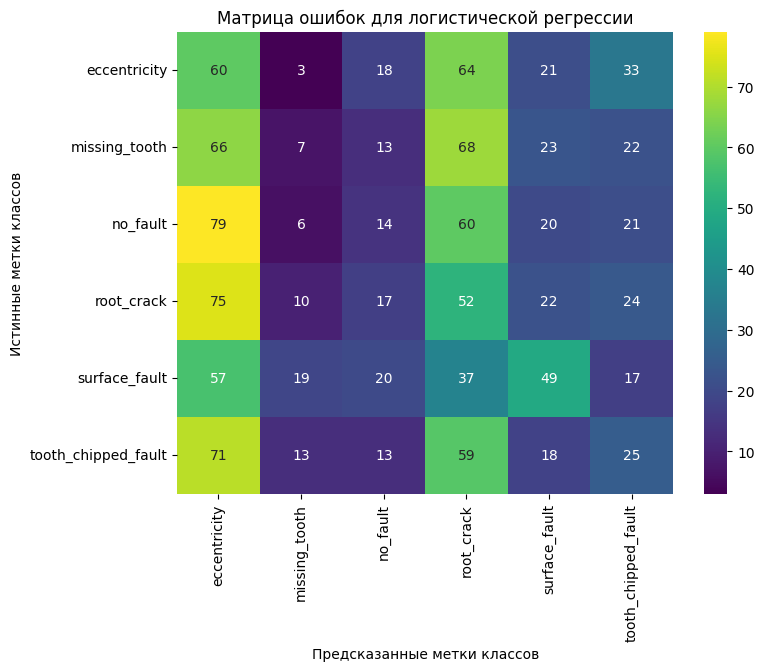

In [12]:
cm = confusion_matrix(y_test, predictions, labels=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='viridis', cbar=True)
plt.xlabel('Предсказанные метки классов')
plt.ylabel('Истинные метки классов')
plt.title('Матрица ошибок для логистической регрессии')
plt.show()

In [13]:
roc_auc_score(y_test, log_reg.predict_proba(X_test), multi_class='ovr')

0.4924467686221466

Дерево решений

In [14]:
def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 100),
        'criterion': 'entropy',
    }
 
    d_tree = DecisionTreeClassifier(**params)
    DecisionTreeClassifier()
    d_tree.fit(X_train, y_train)
    
    preds = d_tree.predict(X_val)
    accuracy = accuracy_score(y_val, preds)
    
    return accuracy

study = optuna.create_study(study_name='Tree', direction='maximize')
study.optimize(objective, n_trials=50)

[I 2024-05-21 00:42:41,554] A new study created in memory with name: Tree
[I 2024-05-21 00:42:44,084] Trial 0 finished with value: 0.3880753138075314 and parameters: {'max_depth': 46}. Best is trial 0 with value: 0.3880753138075314.
[I 2024-05-21 00:42:46,530] Trial 1 finished with value: 0.37447698744769875 and parameters: {'max_depth': 74}. Best is trial 0 with value: 0.3880753138075314.
[I 2024-05-21 00:42:49,079] Trial 2 finished with value: 0.3912133891213389 and parameters: {'max_depth': 71}. Best is trial 2 with value: 0.3912133891213389.
[I 2024-05-21 00:42:50,938] Trial 3 finished with value: 0.34518828451882844 and parameters: {'max_depth': 8}. Best is trial 2 with value: 0.3912133891213389.
[I 2024-05-21 00:42:53,445] Trial 4 finished with value: 0.3880753138075314 and parameters: {'max_depth': 20}. Best is trial 2 with value: 0.3912133891213389.
[I 2024-05-21 00:42:55,926] Trial 5 finished with value: 0.38389121338912136 and parameters: {'max_depth': 82}. Best is trial 2 wi

In [15]:
study.best_params

{'max_depth': 71}

In [16]:
d_tree = DecisionTreeClassifier(**{'max_depth': 21})
d_tree.fit(X_train, y_train)
predictions = d_tree.predict(X_test)
accuracy_array.append(accuracy_score(y_test, predictions))
accuracy_score(y_test, predictions)

0.3896321070234114

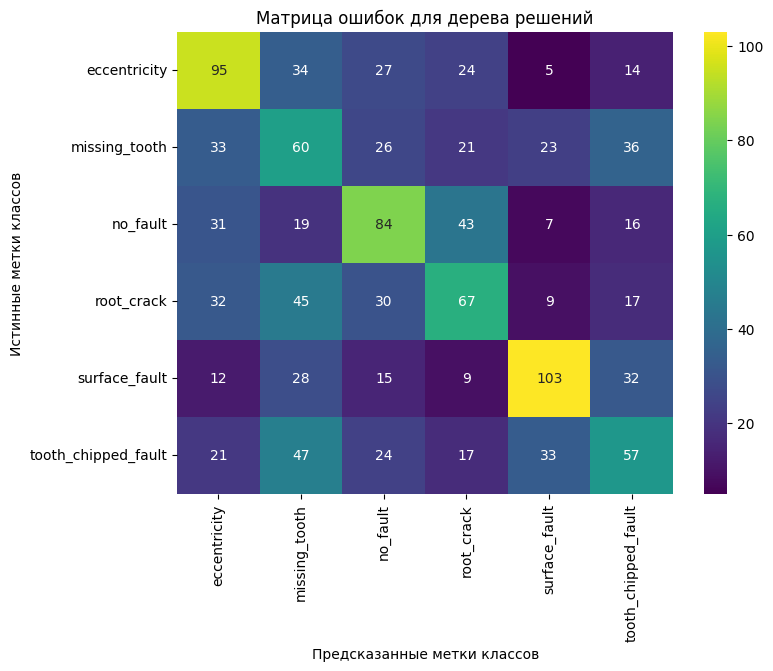

In [17]:
cm = confusion_matrix(y_test, predictions, labels=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='viridis', cbar=True)
plt.xlabel('Предсказанные метки классов')
plt.ylabel('Истинные метки классов')
plt.title('Матрица ошибок для дерева решений')
plt.show()

In [18]:
roc_auc_score(y_test, d_tree.predict_proba(X_test), multi_class='ovr')

0.6337900268601274

Градиентный бустинг

In [19]:
def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 2),
        'num_leaves': trial.suggest_int('num_leaves', 35, 4095),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 100),
        'objective': 'multiclass',
        'random_state': 42,
        'verbose': -1
    }
 
    clf = LGBMClassifier(**params)
    clf.fit(X_train, y_train)
    
    preds = clf.predict(X_val)
    accuracy = accuracy_score(y_val, preds)
    
    return accuracy
    

In [20]:
study = optuna.create_study(direction='maximize', study_name='Boosting')
study.optimize(objective, n_trials=100)

[I 2024-05-21 00:44:49,252] A new study created in memory with name: Boosting
[I 2024-05-21 00:44:51,275] Trial 0 finished with value: 0.6610878661087866 and parameters: {'learning_rate': 0.252150859899231, 'num_leaves': 2938, 'reg_lambda': 0.2206238672422881, 'reg_alpha': 0.48005368486169764, 'min_child_samples': 74}. Best is trial 0 with value: 0.6610878661087866.
[I 2024-05-21 00:44:52,745] Trial 1 finished with value: 0.6297071129707112 and parameters: {'learning_rate': 0.5305710209689022, 'num_leaves': 2828, 'reg_lambda': 0.9200051271671201, 'reg_alpha': 0.8103916645571709, 'min_child_samples': 64}. Best is trial 0 with value: 0.6610878661087866.
[I 2024-05-21 00:44:54,528] Trial 2 finished with value: 0.5826359832635983 and parameters: {'learning_rate': 0.71680579937923, 'num_leaves': 3938, 'reg_lambda': 0.9144122666594465, 'reg_alpha': 0.5252784211924592, 'min_child_samples': 39}. Best is trial 0 with value: 0.6610878661087866.
[I 2024-05-21 00:44:55,754] Trial 3 finished with v

[I 2024-05-21 00:46:21,582] Trial 28 finished with value: 0.6579497907949791 and parameters: {'learning_rate': 0.36485219838402333, 'num_leaves': 3593, 'reg_lambda': 0.061207653301583335, 'reg_alpha': 0.12498417819806232, 'min_child_samples': 77}. Best is trial 11 with value: 0.698744769874477.
[I 2024-05-21 00:46:25,093] Trial 29 finished with value: 0.6809623430962343 and parameters: {'learning_rate': 0.164913558226502, 'num_leaves': 4035, 'reg_lambda': 0.26057438095452545, 'reg_alpha': 0.47621156141044096, 'min_child_samples': 91}. Best is trial 11 with value: 0.698744769874477.
[I 2024-05-21 00:46:26,596] Trial 30 finished with value: 0.6286610878661087 and parameters: {'learning_rate': 0.6539415204945117, 'num_leaves': 2452, 'reg_lambda': 0.10189469719255062, 'reg_alpha': 0.36433125401122085, 'min_child_samples': 77}. Best is trial 11 with value: 0.698744769874477.
[I 2024-05-21 00:46:31,344] Trial 31 finished with value: 0.5209205020920502 and parameters: {'learning_rate': 0.0039

[I 2024-05-21 00:47:46,424] Trial 56 finished with value: 0.6663179916317992 and parameters: {'learning_rate': 0.47146502077839336, 'num_leaves': 2740, 'reg_lambda': 0.08028358553551093, 'reg_alpha': 0.047572544409329884, 'min_child_samples': 82}. Best is trial 54 with value: 0.7018828451882845.
[I 2024-05-21 00:47:49,118] Trial 57 finished with value: 0.6715481171548117 and parameters: {'learning_rate': 0.2233711486953397, 'num_leaves': 1589, 'reg_lambda': 0.1325261416871228, 'reg_alpha': 0.47014167057565964, 'min_child_samples': 89}. Best is trial 54 with value: 0.7018828451882845.
[I 2024-05-21 00:47:52,329] Trial 58 finished with value: 0.6694560669456067 and parameters: {'learning_rate': 0.05976255442108101, 'num_leaves': 899, 'reg_lambda': 0.008828221725453882, 'reg_alpha': 0.2863519494958657, 'min_child_samples': 84}. Best is trial 54 with value: 0.7018828451882845.
[I 2024-05-21 00:47:55,660] Trial 59 finished with value: 0.6746861924686193 and parameters: {'learning_rate': 0.1

[I 2024-05-21 00:49:22,154] Trial 84 finished with value: 0.649581589958159 and parameters: {'learning_rate': 0.4462987900282629, 'num_leaves': 359, 'reg_lambda': 0.1970394879583554, 'reg_alpha': 0.12289162922569695, 'min_child_samples': 63}. Best is trial 68 with value: 0.7154811715481172.
[I 2024-05-21 00:49:26,533] Trial 85 finished with value: 0.6244769874476988 and parameters: {'learning_rate': 0.028677782173577304, 'num_leaves': 1138, 'reg_lambda': 0.07674110921103267, 'reg_alpha': 0.05003470075846661, 'min_child_samples': 77}. Best is trial 68 with value: 0.7154811715481172.
[I 2024-05-21 00:49:31,770] Trial 86 finished with value: 0.6903765690376569 and parameters: {'learning_rate': 0.07685600056354275, 'num_leaves': 927, 'reg_lambda': 0.2288729910838219, 'reg_alpha': 0.08175503942157165, 'min_child_samples': 54}. Best is trial 68 with value: 0.7154811715481172.
[I 2024-05-21 00:49:36,161] Trial 87 finished with value: 0.6914225941422594 and parameters: {'learning_rate': 0.1774

In [21]:
study.best_params

{'learning_rate': 0.33805610161312366,
 'num_leaves': 308,
 'reg_lambda': 0.18421161320160745,
 'reg_alpha': 0.0024734461861862043,
 'min_child_samples': 60}

In [22]:
boosting_clf = LGBMClassifier(verbose=-1, **{'learning_rate': 0.21052069637491053,
 'num_leaves': 1967,
 'reg_lambda': 0.6177114358764701,
 'reg_alpha': 0.2464177355823767,
 'min_child_samples': 91})
boosting_clf.fit(X_train, y_train)
predictions = boosting_clf.predict(X_test)
accuracy_array.append(accuracy_score(y_test, predictions))
accuracy_score(y_test, predictions)

0.6546822742474916

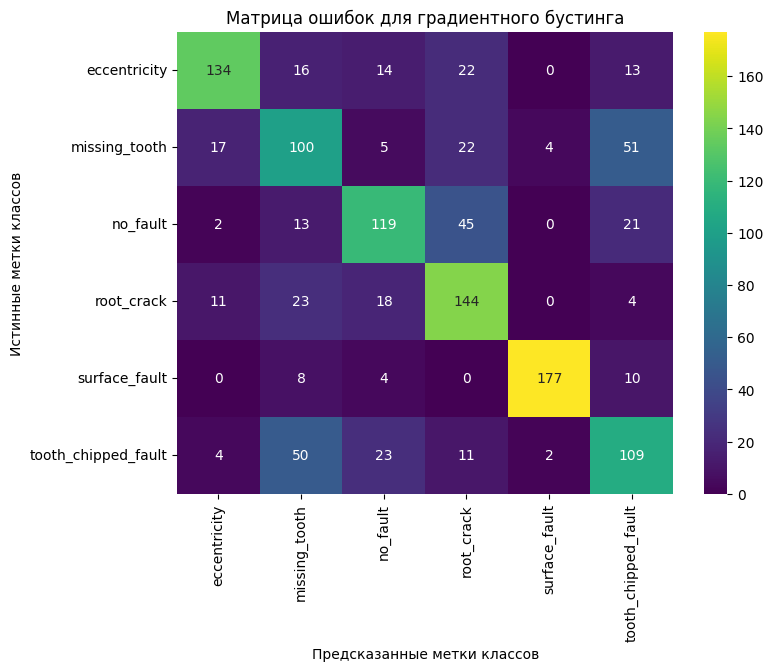

In [23]:
cm = confusion_matrix(y_test, predictions, labels=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='viridis', cbar=True)
plt.xlabel('Предсказанные метки классов')
plt.ylabel('Истинные метки классов')
plt.title('Матрица ошибок для градиентного бустинга')
plt.show()

In [24]:
roc_auc_score(y_test, boosting_clf.predict_proba(X_test), multi_class='ovr')

0.9240082138076353

In [25]:
models_list = ['Логистическая регрессия', 'Дерево решений', 'Градиентный бустинг']
metrics = pd.DataFrame({'Модель': models_list,
                        'Accuracy': np.round(np.array(accuracy_array), 4)})
metrics.to_excel('First_multy.xlsx')


Градиентный бустинг дал лучший результат

**Преобразование Фурье**

In [26]:
df = get_all_features_and_targets(n_cols=150, do_fft=True)
df

,defect,0,1,2,3,4,5,6,7,8,...,68,69,70,71,72,73,74,75,velocity,load
0,eccentricity,3.502729,0.000146,0.000086,0.000172,0.000055,0.000060,0.000043,0.000062,0.000019,...,0.000019,0.000056,0.000122,0.000031,0.000077,0.000115,0.000021,0.000012,8.332031,0.0
1,eccentricity,3.502848,0.000128,0.000102,0.000040,0.000061,0.000095,0.000087,0.000054,0.000067,...,0.000051,0.000080,0.000045,0.000029,0.000071,0.000057,0.000055,0.000008,8.332031,0.0
2,eccentricity,3.502888,0.000166,0.000052,0.000145,0.000031,0.000053,0.000048,0.000029,0.000036,...,0.000066,0.000035,0.000058,0.000041,0.000051,0.000042,0.000064,0.000066,8.332031,0.0
3,eccentricity,3.502932,0.000054,0.000034,0.000103,0.000030,0.000126,0.000040,0.000078,0.000053,...,0.000081,0.000014,0.000112,0.000054,0.000037,0.000080,0.000108,0.000037,8.332031,0.0
4,eccentricity,3.502769,0.000089,0.000050,0.000173,0.000055,0.000050,0.000042,0.000095,0.000013,...,0.000015,0.000069,0.000092,0.000034,0.000047,0.000031,0.000057,0.000097,8.332031,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5971,tooth_chipped_fault,3.501413,0.000639,0.000316,0.000204,0.000598,0.000362,0.000528,0.000334,0.000495,...,0.002562,0.002640,0.001133,0.001922,0.001976,0.000295,0.000403,0.000499,40.000000,80.0
5972,tooth_chipped_fault,3.500628,0.000158,0.000643,0.000391,0.000020,0.000666,0.000235,0.000508,0.000395,...,0.000178,0.000933,0.000999,0.002674,0.000626,0.001075,0.000289,0.000213,40.000000,80.0
5973,tooth_chipped_fault,3.501770,0.000117,0.000608,0.000531,0.000837,0.000095,0.000098,0.000300,0.000257,...,0.001237,0.001694,0.000639,0.002405,0.001804,0.000817,0.001955,0.000754,40.000000,80.0
5974,tooth_chipped_fault,3.500282,0.000077,0.000578,0.000279,0.000504,0.000035,0.000525,0.000670,0.000491,...,0.000518,0.000678,0.000819,0.001685,0.001469,0.001412,0.001168,0.000606,40.000000,80.0


In [27]:
X = df.drop(columns='defect')
y = df['defect']

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, train_size=0.8, random_state=18)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, train_size=0.8, random_state=18)

Логистическая регрессия

In [29]:
accuracy_array = []
log_reg = LogisticRegression(max_iter=100000)
log_reg.fit(X_train, y_train)
predictions = log_reg.predict(X_test)
accuracy_array.append(accuracy_score(y_test, predictions))
accuracy_score(y_test, predictions)

0.23745819397993312

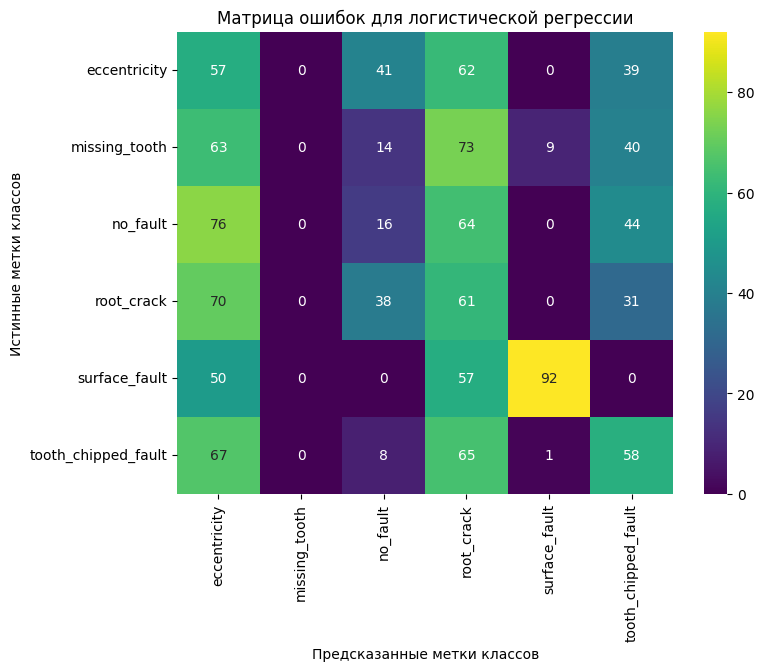

In [30]:
cm = confusion_matrix(y_test, predictions, labels=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='viridis', cbar=True)
plt.xlabel('Предсказанные метки классов')
plt.ylabel('Истинные метки классов')
plt.title('Матрица ошибок для логистической регрессии')
plt.show()

In [31]:
roc_auc_score(y_test, log_reg.predict_proba(X_test), multi_class='ovr')

0.5737211107433148

Дерево решений

In [32]:
def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 100),
        'criterion': 'entropy',
    }
 
    d_tree = DecisionTreeClassifier(**params)
    d_tree.fit(X_train, y_train)
    
    preds = d_tree.predict(X_val)
    accuracy = accuracy_score(y_val, preds)
    
    return accuracy

study = optuna.create_study(study_name='Tree', direction='maximize')
study.optimize(objective, n_trials=50)

[I 2024-05-21 00:50:55,810] A new study created in memory with name: Tree
[I 2024-05-21 00:50:56,664] Trial 0 finished with value: 0.8399581589958159 and parameters: {'max_depth': 67}. Best is trial 0 with value: 0.8399581589958159.
[I 2024-05-21 00:50:57,588] Trial 1 finished with value: 0.8451882845188284 and parameters: {'max_depth': 65}. Best is trial 1 with value: 0.8451882845188284.
[I 2024-05-21 00:50:58,480] Trial 2 finished with value: 0.8514644351464435 and parameters: {'max_depth': 39}. Best is trial 2 with value: 0.8514644351464435.
[I 2024-05-21 00:50:59,329] Trial 3 finished with value: 0.8556485355648535 and parameters: {'max_depth': 61}. Best is trial 3 with value: 0.8556485355648535.
[I 2024-05-21 00:51:00,173] Trial 4 finished with value: 0.856694560669456 and parameters: {'max_depth': 60}. Best is trial 4 with value: 0.856694560669456.
[I 2024-05-21 00:51:01,018] Trial 5 finished with value: 0.8410041841004184 and parameters: {'max_depth': 11}. Best is trial 4 with v

In [33]:
study.best_params

{'max_depth': 31}

In [34]:
d_tree = DecisionTreeClassifier(**{'max_depth': 79})
d_tree.fit(X_train, y_train)
predictions = d_tree.predict(X_test)
accuracy_array.append(accuracy_score(y_test, predictions))
accuracy_score(y_test, predictions)

0.8177257525083612

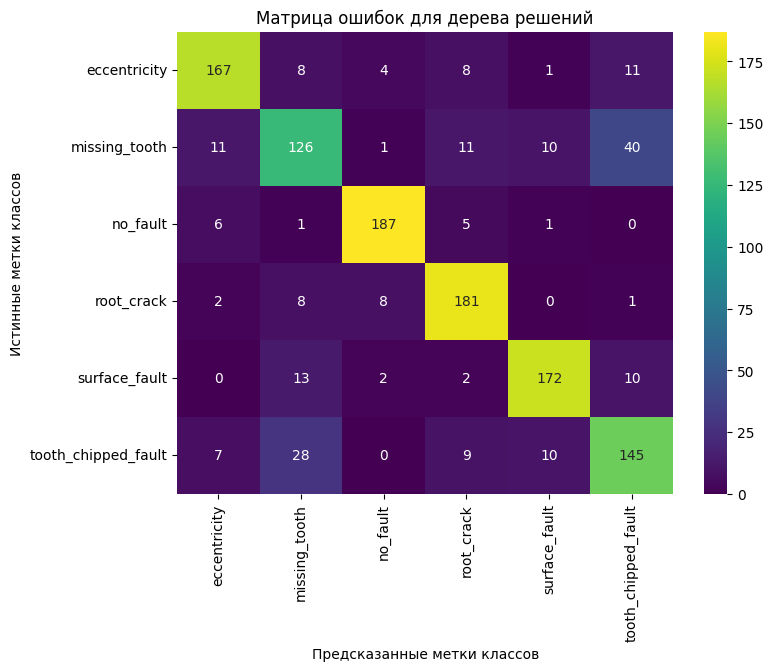

In [35]:
cm = confusion_matrix(y_test, predictions, labels=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='viridis', cbar=True)
plt.xlabel('Предсказанные метки классов')
plt.ylabel('Истинные метки классов')
plt.title('Матрица ошибок для дерева решений')
plt.show()

In [36]:
roc_auc_score(y_test, d_tree.predict_proba(X_test), multi_class='ovr')

0.8905516927836108

Градиентный бустинг

In [37]:
def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 2),
        'num_leaves': trial.suggest_int('num_leaves', 35, 4095),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 100),
        'objective': 'multiclass',
        'random_state': 42,
        'verbose': -1
    }
 
    clf = LGBMClassifier(**params)
    clf.fit(X_train, y_train)
    
    preds = clf.predict(X_val)
    accuracy = accuracy_score(y_val, preds)
    
    return accuracy
    

In [38]:
study = optuna.create_study(direction='maximize', study_name='Boosting')
study.optimize(objective, n_trials=100)

[I 2024-05-21 00:51:38,664] A new study created in memory with name: Boosting
[I 2024-05-21 00:51:39,126] Trial 0 finished with value: 0.9006276150627615 and parameters: {'learning_rate': 1.1689162605681989, 'num_leaves': 2997, 'reg_lambda': 0.7178051094123756, 'reg_alpha': 0.7549502653719747, 'min_child_samples': 62}. Best is trial 0 with value: 0.9006276150627615.
[I 2024-05-21 00:51:39,330] Trial 1 finished with value: 0.9110878661087866 and parameters: {'learning_rate': 1.0959025954081345, 'num_leaves': 366, 'reg_lambda': 0.10722985391637851, 'reg_alpha': 0.44943342832842537, 'min_child_samples': 76}. Best is trial 1 with value: 0.9110878661087866.
[I 2024-05-21 00:51:39,818] Trial 2 finished with value: 0.9006276150627615 and parameters: {'learning_rate': 1.0049031632419039, 'num_leaves': 2527, 'reg_lambda': 0.15529131483609648, 'reg_alpha': 0.7363744967219307, 'min_child_samples': 38}. Best is trial 1 with value: 0.9110878661087866.
[I 2024-05-21 00:51:40,438] Trial 3 finished wi

[I 2024-05-21 00:52:07,886] Trial 28 finished with value: 0.9592050209205021 and parameters: {'learning_rate': 0.15042929081856085, 'num_leaves': 822, 'reg_lambda': 0.6094508712756768, 'reg_alpha': 0.1871002663925201, 'min_child_samples': 84}. Best is trial 12 with value: 0.9592050209205021.
[I 2024-05-21 00:52:09,004] Trial 29 finished with value: 0.9571129707112971 and parameters: {'learning_rate': 0.12247293013715516, 'num_leaves': 648, 'reg_lambda': 0.6903333867872281, 'reg_alpha': 0.4208770062320354, 'min_child_samples': 100}. Best is trial 12 with value: 0.9592050209205021.
[I 2024-05-21 00:52:10,297] Trial 30 finished with value: 0.8786610878661087 and parameters: {'learning_rate': 0.010066837319203825, 'num_leaves': 1612, 'reg_lambda': 0.8207657196305693, 'reg_alpha': 0.3052759854424325, 'min_child_samples': 90}. Best is trial 12 with value: 0.9592050209205021.
[I 2024-05-21 00:52:11,309] Trial 31 finished with value: 0.9581589958158996 and parameters: {'learning_rate': 0.16199

[I 2024-05-21 00:52:36,766] Trial 56 finished with value: 0.9518828451882845 and parameters: {'learning_rate': 0.31615970363509527, 'num_leaves': 817, 'reg_lambda': 0.6469072189190593, 'reg_alpha': 0.3962416945117281, 'min_child_samples': 83}. Best is trial 34 with value: 0.9623430962343096.
[I 2024-05-21 00:52:39,032] Trial 57 finished with value: 0.9550209205020921 and parameters: {'learning_rate': 0.05398759010616064, 'num_leaves': 4084, 'reg_lambda': 0.5043034135385404, 'reg_alpha': 0.4563990202921732, 'min_child_samples': 91}. Best is trial 34 with value: 0.9623430962343096.
[I 2024-05-21 00:52:40,482] Trial 58 finished with value: 0.9550209205020921 and parameters: {'learning_rate': 0.2314388929770344, 'num_leaves': 2151, 'reg_lambda': 0.7786413792300375, 'reg_alpha': 0.21572720054037217, 'min_child_samples': 78}. Best is trial 34 with value: 0.9623430962343096.
[I 2024-05-21 00:52:41,278] Trial 59 finished with value: 0.9560669456066946 and parameters: {'learning_rate': 0.466168

[I 2024-05-21 00:53:14,640] Trial 84 finished with value: 0.9539748953974896 and parameters: {'learning_rate': 0.05601979075077309, 'num_leaves': 573, 'reg_lambda': 0.9623974325658368, 'reg_alpha': 0.1846586351868063, 'min_child_samples': 78}. Best is trial 34 with value: 0.9623430962343096.
[I 2024-05-21 00:53:15,938] Trial 85 finished with value: 0.9560669456066946 and parameters: {'learning_rate': 0.15306120451728572, 'num_leaves': 1113, 'reg_lambda': 0.9155212699521431, 'reg_alpha': 0.14572471562655218, 'min_child_samples': 91}. Best is trial 34 with value: 0.9623430962343096.
[I 2024-05-21 00:53:17,419] Trial 86 finished with value: 0.9571129707112971 and parameters: {'learning_rate': 0.20962687313587264, 'num_leaves': 826, 'reg_lambda': 0.8743790929551991, 'reg_alpha': 0.010306130464108623, 'min_child_samples': 85}. Best is trial 34 with value: 0.9623430962343096.
[I 2024-05-21 00:53:18,881] Trial 87 finished with value: 0.9560669456066946 and parameters: {'learning_rate': 0.1130

In [39]:
study.best_params

{'learning_rate': 0.27701273524685227,
 'num_leaves': 768,
 'reg_lambda': 0.8563650030182685,
 'reg_alpha': 0.2963381428059686,
 'min_child_samples': 82}

In [40]:
best_params = {'learning_rate': 0.2403462227354661,
 'num_leaves': 3463,
 'reg_lambda': 0.003914470135492306,
 'reg_alpha': 0.0961882352006507,
 'min_child_samples': 99}

In [41]:
boosting_clf = LGBMClassifier(verbose=-1, **study.best_params)
boosting_clf.fit(X_train, y_train)
predictions = boosting_clf.predict(X_test)
accuracy_array.append(accuracy_score(y_test, predictions))
accuracy_score(y_test, predictions)

0.9498327759197325

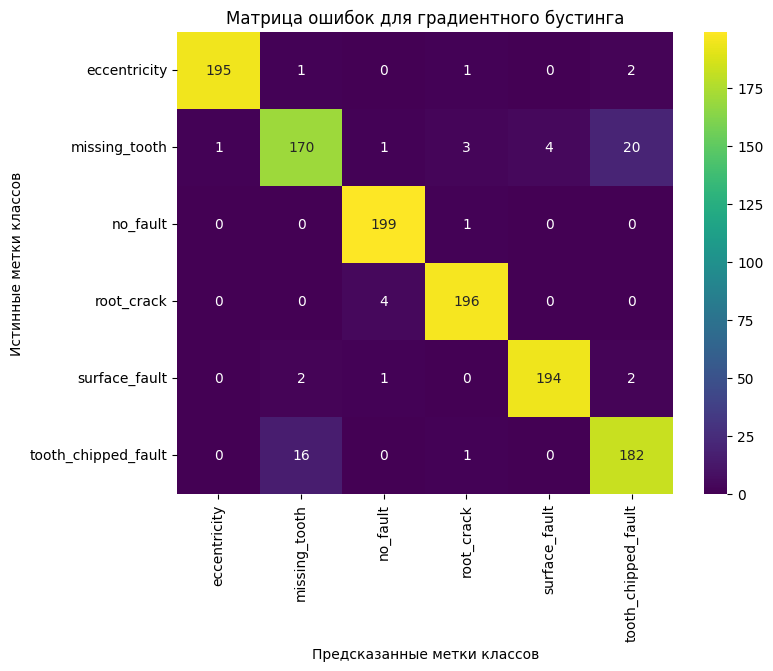

In [42]:
cm = confusion_matrix(y_test, predictions, labels=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='viridis', cbar=True)
plt.xlabel('Предсказанные метки классов')
plt.ylabel('Истинные метки классов')
plt.title('Матрица ошибок для градиентного бустинга')
plt.show()

In [43]:
roc_auc_score(y_test, boosting_clf.predict_proba(X_test), multi_class='ovr')

0.9970461335150063

In [44]:
models_list = ['Логистическая регрессия', 'Дерево решений', 'Градиентный бустинг']
metrics = pd.DataFrame({'Модель': models_list,
                        'Accuracy': np.round(np.array(accuracy_array), 4)})
metrics.to_excel('Second_multy.xlsx')


## Бинарная классификация

In [45]:
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

In [46]:
df = get_all_features_and_targets(n_cols=150, do_fft=False)
df

,defect,0,1,2,3,4,5,6,7,8,...,142,143,144,145,146,147,148,149,velocity,load
0,eccentricity,3.503794,3.504284,3.501296,3.502646,3.502895,3.504385,3.501738,3.501451,3.502886,...,3.502059,3.502401,3.502008,3.502532,3.502168,3.503452,3.502139,3.503672,8.332031,0.0
1,eccentricity,3.502760,3.501581,3.502624,3.502988,3.502616,3.503119,3.502050,3.502033,3.501911,...,3.505095,3.502054,3.502726,3.504403,3.503815,3.503268,3.502291,3.504622,8.332031,0.0
2,eccentricity,3.503811,3.504516,3.502063,3.503334,3.504596,3.505016,3.503701,3.502291,3.503794,...,3.503545,3.502848,3.503642,3.503317,3.501953,3.502046,3.503060,3.502029,8.332031,0.0
3,eccentricity,3.504140,3.501932,3.502958,3.501358,3.500961,3.503009,3.502646,3.499939,3.502037,...,3.503828,3.502882,3.502886,3.503351,3.503136,3.501852,3.502624,3.503815,8.332031,0.0
4,eccentricity,3.502794,3.503614,3.502059,3.502536,3.503579,3.504297,3.503097,3.501358,3.503313,...,3.502295,3.500526,3.504702,3.503330,3.503921,3.501852,3.503500,3.502620,8.332031,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5971,tooth_chipped_fault,3.521564,3.467792,3.529033,3.476408,3.491611,3.510696,3.500587,3.520705,3.507101,...,3.526941,3.489998,3.473191,3.521295,3.508953,3.482174,3.528465,3.495734,40.000000,80.0
5972,tooth_chipped_fault,3.508022,3.502168,3.512502,3.490336,3.486260,3.501365,3.503475,3.486040,3.515675,...,3.502200,3.511373,3.479453,3.514994,3.487915,3.502930,3.515036,3.491246,40.000000,80.0
5973,tooth_chipped_fault,3.491869,3.521329,3.516670,3.479993,3.515390,3.498440,3.502553,3.490516,3.499569,...,3.486196,3.502972,3.485496,3.507658,3.504914,3.485691,3.488048,3.516261,40.000000,80.0
5974,tooth_chipped_fault,3.490405,3.501801,3.503596,3.499653,3.522508,3.493943,3.497095,3.497760,3.501318,...,3.502893,3.520132,3.499816,3.505469,3.492069,3.504319,3.481774,3.492658,40.000000,80.0


In [47]:
df['defect'] = np.where(df['defect'] == 'no_fault', 0, 1)
df

,defect,0,1,2,3,4,5,6,7,8,...,142,143,144,145,146,147,148,149,velocity,load
0,1,3.503794,3.504284,3.501296,3.502646,3.502895,3.504385,3.501738,3.501451,3.502886,...,3.502059,3.502401,3.502008,3.502532,3.502168,3.503452,3.502139,3.503672,8.332031,0.0
1,1,3.502760,3.501581,3.502624,3.502988,3.502616,3.503119,3.502050,3.502033,3.501911,...,3.505095,3.502054,3.502726,3.504403,3.503815,3.503268,3.502291,3.504622,8.332031,0.0
2,1,3.503811,3.504516,3.502063,3.503334,3.504596,3.505016,3.503701,3.502291,3.503794,...,3.503545,3.502848,3.503642,3.503317,3.501953,3.502046,3.503060,3.502029,8.332031,0.0
3,1,3.504140,3.501932,3.502958,3.501358,3.500961,3.503009,3.502646,3.499939,3.502037,...,3.503828,3.502882,3.502886,3.503351,3.503136,3.501852,3.502624,3.503815,8.332031,0.0
4,1,3.502794,3.503614,3.502059,3.502536,3.503579,3.504297,3.503097,3.501358,3.503313,...,3.502295,3.500526,3.504702,3.503330,3.503921,3.501852,3.503500,3.502620,8.332031,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5971,1,3.521564,3.467792,3.529033,3.476408,3.491611,3.510696,3.500587,3.520705,3.507101,...,3.526941,3.489998,3.473191,3.521295,3.508953,3.482174,3.528465,3.495734,40.000000,80.0
5972,1,3.508022,3.502168,3.512502,3.490336,3.486260,3.501365,3.503475,3.486040,3.515675,...,3.502200,3.511373,3.479453,3.514994,3.487915,3.502930,3.515036,3.491246,40.000000,80.0
5973,1,3.491869,3.521329,3.516670,3.479993,3.515390,3.498440,3.502553,3.490516,3.499569,...,3.486196,3.502972,3.485496,3.507658,3.504914,3.485691,3.488048,3.516261,40.000000,80.0
5974,1,3.490405,3.501801,3.503596,3.499653,3.522508,3.493943,3.497095,3.497760,3.501318,...,3.502893,3.520132,3.499816,3.505469,3.492069,3.504319,3.481774,3.492658,40.000000,80.0


In [48]:
X = df.drop(columns='defect')
y = df['defect']

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, train_size=0.8, random_state=18)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, train_size=0.8, random_state=18)

In [50]:
labels = [1, 0]

Логистическая регрессия

In [51]:
accuracy_array = []
roc_auc_array = []
precision_array = []
recall_array = []
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
predictions = log_reg.predict(X_test)
accuracy_array.append(accuracy_score(y_test, predictions))
accuracy_score(y_test, predictions)

0.8336120401337793

In [52]:
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
roc_auc = roc_auc_score(y_test, log_reg.predict_proba(X_test)[:, 1])
roc_auc_array.append(roc_auc)
precision_array.append(precision)
recall_array.append(recall)
print(f"Precision = {precision}")
print(f"Recall = {recall}")
print(f"f1 = {f1}")
print(f"roc_auc = {roc_auc}")

Precision = 0.8336120401337793
Recall = 1.0
f1 = 0.9092567259461924
roc_auc = 0.4457644289652879


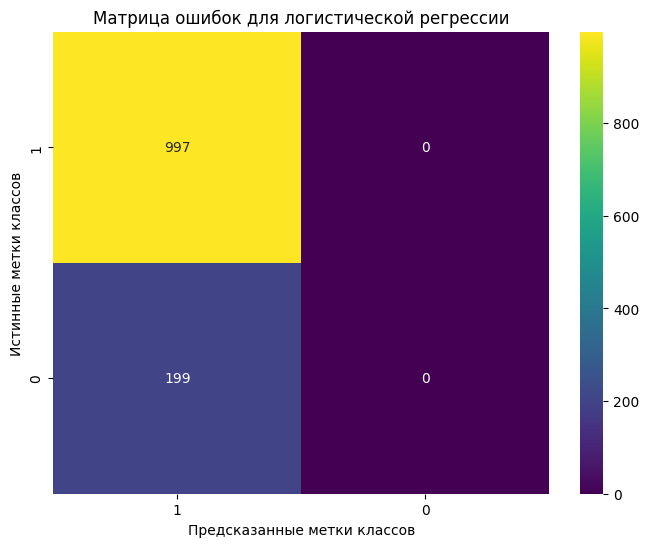

In [53]:
cm = confusion_matrix(y_test, predictions, labels=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='viridis', cbar=True)
plt.xlabel('Предсказанные метки классов')
plt.ylabel('Истинные метки классов')
plt.title('Матрица ошибок для логистической регрессии')
plt.show()

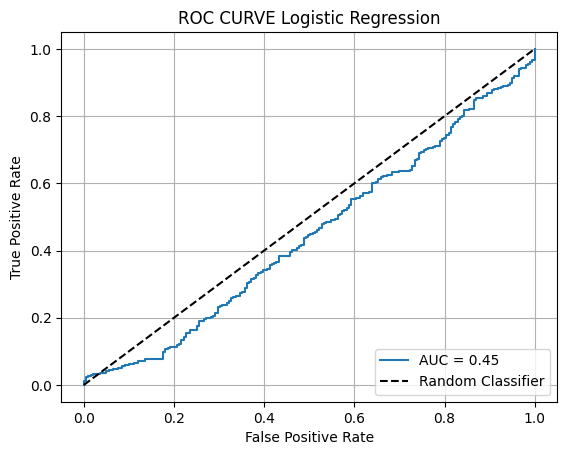

In [54]:
y_pred_proba = log_reg.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot (fpr,tpr,label=f"AUC = {round(auc, 2)}")
plt.plot([0, 1], [0, 1], '--k', label='Random Classifier')
plt.grid()
plt.title('ROC CURVE Logistic Regression')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show() 

Дерево решений

In [55]:
def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 100),
        'criterion': 'entropy',
    }
 
    d_tree = DecisionTreeClassifier(**params)
    d_tree.fit(X_train, y_train)
    
    preds = d_tree.predict_proba(X_val)[:, 1]
    roc_auc = roc_auc_score(y_val, preds)
    
    return roc_auc

study = optuna.create_study(study_name='Tree', direction='maximize')
study.optimize(objective, n_trials=50)

[I 2024-05-21 00:54:55,152] A new study created in memory with name: Tree
[I 2024-05-21 00:54:56,433] Trial 0 finished with value: 0.6794031075653196 and parameters: {'max_depth': 53}. Best is trial 0 with value: 0.6794031075653196.
[I 2024-05-21 00:54:57,713] Trial 1 finished with value: 0.6548890098877078 and parameters: {'max_depth': 29}. Best is trial 0 with value: 0.6794031075653196.
[I 2024-05-21 00:54:58,406] Trial 2 finished with value: 0.697793612840605 and parameters: {'max_depth': 4}. Best is trial 2 with value: 0.697793612840605.
[I 2024-05-21 00:54:59,739] Trial 3 finished with value: 0.6611704268364857 and parameters: {'max_depth': 80}. Best is trial 2 with value: 0.697793612840605.
[I 2024-05-21 00:55:01,020] Trial 4 finished with value: 0.6435729899071203 and parameters: {'max_depth': 66}. Best is trial 2 with value: 0.697793612840605.
[I 2024-05-21 00:55:02,349] Trial 5 finished with value: 0.6504817594280439 and parameters: {'max_depth': 16}. Best is trial 2 with valu

In [56]:
study.best_params

{'max_depth': 6}

In [57]:
d_tree = DecisionTreeClassifier(**{'max_depth': 6})
d_tree.fit(X_train, y_train)
predictions = d_tree.predict(X_test)
accuracy_array.append(accuracy_score(y_test, predictions))
accuracy_score(y_test, predictions)

0.7817725752508361

In [58]:
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
roc_auc = roc_auc_score(y_test, d_tree.predict_proba(X_test)[:, 1])
roc_auc_array.append(roc_auc)
precision_array.append(precision)
recall_array.append(recall)
print(f"Precision = {precision}")
print(f"Recall = {recall}")
print(f"f1 = {f1}")
print(f"roc_auc = {roc_auc}")

Precision = 0.8732251521298174
Recall = 0.8635907723169508
f1 = 0.8683812405446294
roc_auc = 0.7044399530249039


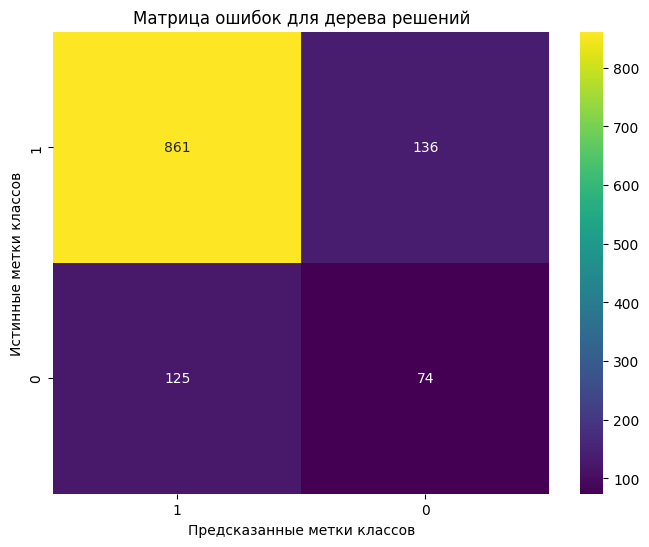

In [59]:
cm = confusion_matrix(y_test, predictions, labels=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='viridis', cbar=True)
plt.xlabel('Предсказанные метки классов')
plt.ylabel('Истинные метки классов')
plt.title('Матрица ошибок для дерева решений')
plt.show()

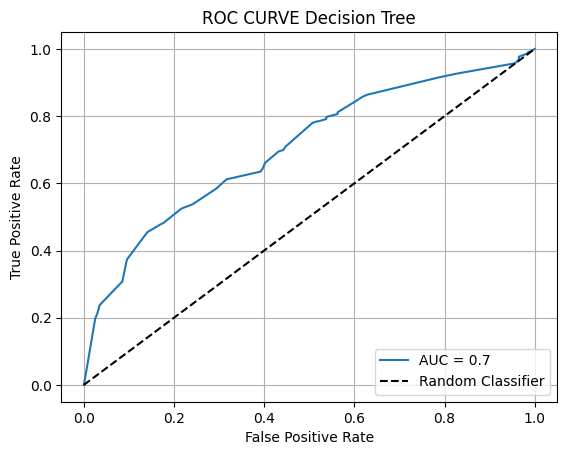

In [60]:
y_pred_proba = d_tree.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot (fpr,tpr,label=f"AUC = {round(auc, 2)}")
plt.plot([0, 1], [0, 1], '--k', label='Random Classifier')
plt.grid()
plt.title('ROC CURVE Decision Tree')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show() 


Градиентный бустинг

In [61]:
def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 2),
        'num_leaves': trial.suggest_int('num_leaves', 35, 4095),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 100),
        'objective': 'binary',
        'random_state': 42,
        'verbose': -1
    }
 
    clf = LGBMClassifier(**params)
    clf.fit(X_train, y_train)
    
    preds = clf.predict_proba(X_val)[:, 1]
    roc_auc = roc_auc_score(y_val, preds)
    
    return roc_auc
    

In [62]:
study = optuna.create_study(direction='maximize', study_name='Boosting')
study.optimize(objective, n_trials=100)

[I 2024-05-21 00:55:59,260] A new study created in memory with name: Boosting
[I 2024-05-21 00:55:59,939] Trial 0 finished with value: 0.6608705601982275 and parameters: {'learning_rate': 1.8502548049992815, 'num_leaves': 2459, 'reg_lambda': 0.5605295673529833, 'reg_alpha': 0.45749461919452306, 'min_child_samples': 31}. Best is trial 0 with value: 0.6608705601982275.
[I 2024-05-21 00:56:01,252] Trial 1 finished with value: 0.9024802127474886 and parameters: {'learning_rate': 0.02167028896523386, 'num_leaves': 3709, 'reg_lambda': 0.5738671397783041, 'reg_alpha': 0.3551673804489839, 'min_child_samples': 48}. Best is trial 1 with value: 0.9024802127474886.
[I 2024-05-21 00:56:01,632] Trial 2 finished with value: 0.8670486020690799 and parameters: {'learning_rate': 1.289317495378179, 'num_leaves': 1742, 'reg_lambda': 0.406854070518349, 'reg_alpha': 0.6002232045935503, 'min_child_samples': 93}. Best is trial 1 with value: 0.9024802127474886.
[I 2024-05-21 00:56:02,015] Trial 3 finished with

[I 2024-05-21 00:56:24,749] Trial 28 finished with value: 0.8878419860640925 and parameters: {'learning_rate': 0.44909696273260236, 'num_leaves': 3550, 'reg_lambda': 0.6825433961954228, 'reg_alpha': 0.8965939536242377, 'min_child_samples': 73}. Best is trial 26 with value: 0.9307781539262803.
[I 2024-05-21 00:56:26,123] Trial 29 finished with value: 0.9154297167838514 and parameters: {'learning_rate': 0.3172191122712843, 'num_leaves': 4040, 'reg_lambda': 0.7075643074060296, 'reg_alpha': 0.5190527338546768, 'min_child_samples': 63}. Best is trial 26 with value: 0.9307781539262803.
[I 2024-05-21 00:56:27,318] Trial 30 finished with value: 0.9272902314496974 and parameters: {'learning_rate': 0.12513322224518728, 'num_leaves': 2747, 'reg_lambda': 0.8068591710570755, 'reg_alpha': 0.6055684989843495, 'min_child_samples': 74}. Best is trial 26 with value: 0.9307781539262803.
[I 2024-05-21 00:56:28,453] Trial 31 finished with value: 0.9228001231031463 and parameters: {'learning_rate': 0.131313

[I 2024-05-21 00:56:56,295] Trial 56 finished with value: 0.9198093479478864 and parameters: {'learning_rate': 0.3296207233723335, 'num_leaves': 2857, 'reg_lambda': 0.5361265262305795, 'reg_alpha': 0.6975746396333418, 'min_child_samples': 84}. Best is trial 34 with value: 0.933903079946024.
[I 2024-05-21 00:56:57,685] Trial 57 finished with value: 0.9250649053447282 and parameters: {'learning_rate': 0.19223833924283956, 'num_leaves': 3302, 'reg_lambda': 0.32174366123515236, 'reg_alpha': 0.651078385379948, 'min_child_samples': 28}. Best is trial 34 with value: 0.933903079946024.
[I 2024-05-21 00:56:58,801] Trial 58 finished with value: 0.920653709271403 and parameters: {'learning_rate': 0.08297474447530477, 'num_leaves': 2586, 'reg_lambda': 0.7604243973002599, 'reg_alpha': 0.762294811274824, 'min_child_samples': 60}. Best is trial 34 with value: 0.933903079946024.
[I 2024-05-21 00:56:59,907] Trial 59 finished with value: 0.9121548574449784 and parameters: {'learning_rate': 0.40656005449

[I 2024-05-21 00:57:27,089] Trial 85 finished with value: 0.9271324069032456 and parameters: {'learning_rate': 0.19196571719545943, 'num_leaves': 772, 'reg_lambda': 0.7449069163952258, 'reg_alpha': 0.616284665266125, 'min_child_samples': 49}. Best is trial 70 with value: 0.9377461076521231.
[I 2024-05-21 00:57:27,834] Trial 86 finished with value: 0.9141355555029475 and parameters: {'learning_rate': 0.29906399625855207, 'num_leaves': 53, 'reg_lambda': 0.8519615461504896, 'reg_alpha': 0.5836509217649883, 'min_child_samples': 28}. Best is trial 70 with value: 0.9377461076521231.
[I 2024-05-21 00:57:28,999] Trial 87 finished with value: 0.9108370224821065 and parameters: {'learning_rate': 0.04116055831216278, 'num_leaves': 252, 'reg_lambda': 0.885289338849128, 'reg_alpha': 0.6547889179393139, 'min_child_samples': 38}. Best is trial 70 with value: 0.9377461076521231.
[I 2024-05-21 00:57:30,183] Trial 88 finished with value: 0.8156293648351128 and parameters: {'learning_rate': 0.00250972495

In [63]:
study.best_params

{'learning_rate': 0.1218763484401705,
 'num_leaves': 1203,
 'reg_lambda': 0.7717989730279518,
 'reg_alpha': 0.6325161530718508,
 'min_child_samples': 46}

In [64]:
boosting_clf = LGBMClassifier(verbose=-1, **{'learning_rate': 0.15354780013017905,
 'num_leaves': 3720,
 'reg_lambda': 0.09044505520222441,
 'reg_alpha': 0.0005937441498047198,
 'min_child_samples': 36})
boosting_clf.fit(X_train, y_train)
predictions = boosting_clf.predict(X_test)
accuracy_array.append(accuracy_score(y_test, predictions))
accuracy_score(y_test, predictions)

0.8954849498327759

In [65]:
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
roc_auc = roc_auc_score(y_test, boosting_clf.predict_proba(X_test)[:, 1])
roc_auc_array.append(roc_auc)
precision_array.append(precision)
recall_array.append(recall)
print(f"Precision = {precision}")
print(f"Recall = {recall}")
print(f"f1 = {f1}")
print(f"roc_auc = {roc_auc}")

Precision = 0.8920863309352518
Recall = 0.9949849548645938
f1 = 0.9407302038880986
roc_auc = 0.9410694394742014


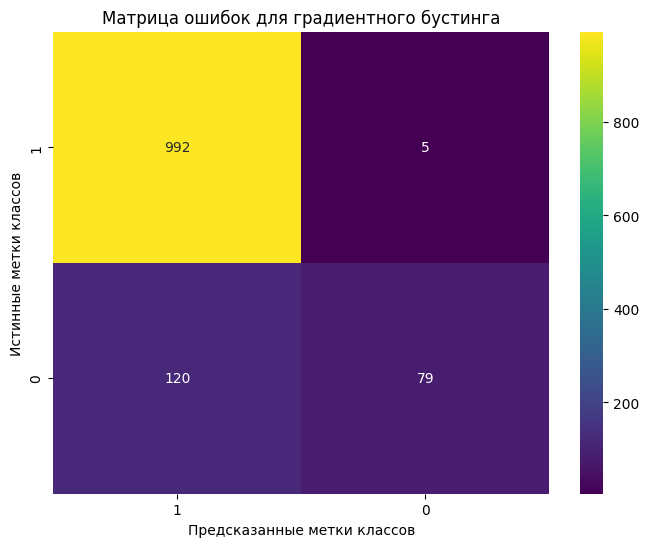

In [66]:
cm = confusion_matrix(y_test, predictions, labels=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='viridis', cbar=True)
plt.xlabel('Предсказанные метки классов')
plt.ylabel('Истинные метки классов')
plt.title('Матрица ошибок для градиентного бустинга')
plt.show()

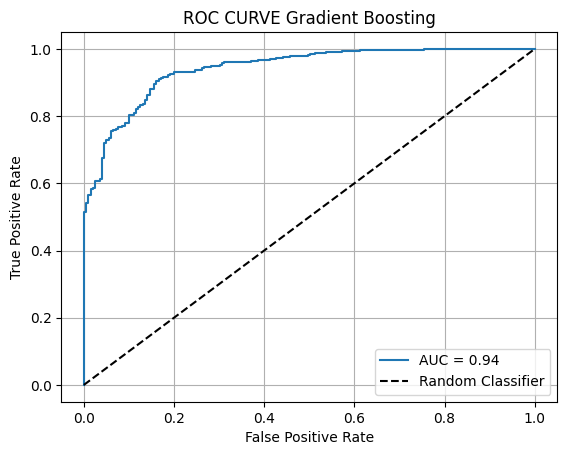

In [67]:
y_pred_proba = boosting_clf.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot (fpr,tpr,label=f"AUC = {round(auc, 2)}")
plt.plot([0, 1], [0, 1], '--k', label='Random Classifier')
plt.grid()
plt.title('ROC CURVE Gradient Boosting')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show() 

In [68]:
models_list = ['Логистическая регрессия', 'Дерево решений', 'Градиентный бустинг']
metrics = pd.DataFrame({'Модель': models_list,
                        'Accuracy': np.round(np.array(accuracy_array), 4),
                       'Precision': np.round(np.array(precision_array), 4),
                       'Recall': np.round(np.array(recall_array), 4),
                       'AUC ROC': np.round(np.array(roc_auc_array), 4)})
metrics.to_excel('First_binary.xlsx')

**Фурье**

In [94]:
df = get_all_features_and_targets(n_cols=150, do_fft=True)
df

,defect,0,1,2,3,4,5,6,7,8,...,68,69,70,71,72,73,74,75,velocity,load
0,eccentricity,3.502729,0.000146,0.000086,0.000172,0.000055,0.000060,0.000043,0.000062,0.000019,...,0.000019,0.000056,0.000122,0.000031,0.000077,0.000115,0.000021,0.000012,8.332031,0.0
1,eccentricity,3.502848,0.000128,0.000102,0.000040,0.000061,0.000095,0.000087,0.000054,0.000067,...,0.000051,0.000080,0.000045,0.000029,0.000071,0.000057,0.000055,0.000008,8.332031,0.0
2,eccentricity,3.502888,0.000166,0.000052,0.000145,0.000031,0.000053,0.000048,0.000029,0.000036,...,0.000066,0.000035,0.000058,0.000041,0.000051,0.000042,0.000064,0.000066,8.332031,0.0
3,eccentricity,3.502932,0.000054,0.000034,0.000103,0.000030,0.000126,0.000040,0.000078,0.000053,...,0.000081,0.000014,0.000112,0.000054,0.000037,0.000080,0.000108,0.000037,8.332031,0.0
4,eccentricity,3.502769,0.000089,0.000050,0.000173,0.000055,0.000050,0.000042,0.000095,0.000013,...,0.000015,0.000069,0.000092,0.000034,0.000047,0.000031,0.000057,0.000097,8.332031,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5971,tooth_chipped_fault,3.501413,0.000639,0.000316,0.000204,0.000598,0.000362,0.000528,0.000334,0.000495,...,0.002562,0.002640,0.001133,0.001922,0.001976,0.000295,0.000403,0.000499,40.000000,80.0
5972,tooth_chipped_fault,3.500628,0.000158,0.000643,0.000391,0.000020,0.000666,0.000235,0.000508,0.000395,...,0.000178,0.000933,0.000999,0.002674,0.000626,0.001075,0.000289,0.000213,40.000000,80.0
5973,tooth_chipped_fault,3.501770,0.000117,0.000608,0.000531,0.000837,0.000095,0.000098,0.000300,0.000257,...,0.001237,0.001694,0.000639,0.002405,0.001804,0.000817,0.001955,0.000754,40.000000,80.0
5974,tooth_chipped_fault,3.500282,0.000077,0.000578,0.000279,0.000504,0.000035,0.000525,0.000670,0.000491,...,0.000518,0.000678,0.000819,0.001685,0.001469,0.001412,0.001168,0.000606,40.000000,80.0


In [95]:
df['defect'] = np.where(df['defect'] == 'no_fault', 0, 1)
df

,defect,0,1,2,3,4,5,6,7,8,...,68,69,70,71,72,73,74,75,velocity,load
0,1,3.502729,0.000146,0.000086,0.000172,0.000055,0.000060,0.000043,0.000062,0.000019,...,0.000019,0.000056,0.000122,0.000031,0.000077,0.000115,0.000021,0.000012,8.332031,0.0
1,1,3.502848,0.000128,0.000102,0.000040,0.000061,0.000095,0.000087,0.000054,0.000067,...,0.000051,0.000080,0.000045,0.000029,0.000071,0.000057,0.000055,0.000008,8.332031,0.0
2,1,3.502888,0.000166,0.000052,0.000145,0.000031,0.000053,0.000048,0.000029,0.000036,...,0.000066,0.000035,0.000058,0.000041,0.000051,0.000042,0.000064,0.000066,8.332031,0.0
3,1,3.502932,0.000054,0.000034,0.000103,0.000030,0.000126,0.000040,0.000078,0.000053,...,0.000081,0.000014,0.000112,0.000054,0.000037,0.000080,0.000108,0.000037,8.332031,0.0
4,1,3.502769,0.000089,0.000050,0.000173,0.000055,0.000050,0.000042,0.000095,0.000013,...,0.000015,0.000069,0.000092,0.000034,0.000047,0.000031,0.000057,0.000097,8.332031,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5971,1,3.501413,0.000639,0.000316,0.000204,0.000598,0.000362,0.000528,0.000334,0.000495,...,0.002562,0.002640,0.001133,0.001922,0.001976,0.000295,0.000403,0.000499,40.000000,80.0
5972,1,3.500628,0.000158,0.000643,0.000391,0.000020,0.000666,0.000235,0.000508,0.000395,...,0.000178,0.000933,0.000999,0.002674,0.000626,0.001075,0.000289,0.000213,40.000000,80.0
5973,1,3.501770,0.000117,0.000608,0.000531,0.000837,0.000095,0.000098,0.000300,0.000257,...,0.001237,0.001694,0.000639,0.002405,0.001804,0.000817,0.001955,0.000754,40.000000,80.0
5974,1,3.500282,0.000077,0.000578,0.000279,0.000504,0.000035,0.000525,0.000670,0.000491,...,0.000518,0.000678,0.000819,0.001685,0.001469,0.001412,0.001168,0.000606,40.000000,80.0


In [96]:
X = df.drop(columns='defect')
y = df['defect']

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, train_size=0.8, random_state=18)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, train_size=0.8, random_state=18)

Логистическая регрессия

In [98]:
accuracy_array = []
roc_auc_array = []
precision_array = []
recall_array = []
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
predictions = log_reg.predict(X_test)
accuracy_array.append(accuracy_score(y_test, predictions))
accuracy_score(y_test, predictions)

0.8336120401337793

In [99]:
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
roc_auc = roc_auc_score(y_test, log_reg.predict_proba(X_test)[:, 1])
roc_auc_array.append(roc_auc)
precision_array.append(precision)
recall_array.append(recall)
print(f"Precision = {precision}")
print(f"Recall = {recall}")
print(f"roc_auc = {roc_auc}")

Precision = 0.8336120401337793
Recall = 1.0
roc_auc = 0.5166907758451234


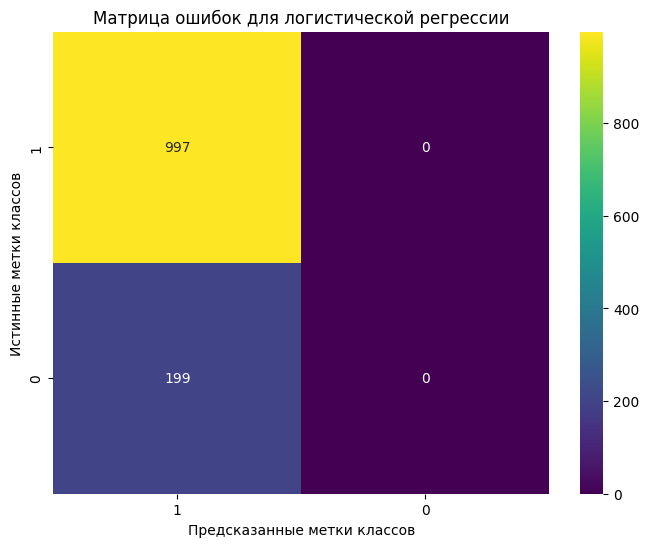

In [100]:
cm = confusion_matrix(y_test, predictions, labels=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='viridis', cbar=True)
plt.xlabel('Предсказанные метки классов')
plt.ylabel('Истинные метки классов')
plt.title('Матрица ошибок для логистической регрессии')
plt.show()

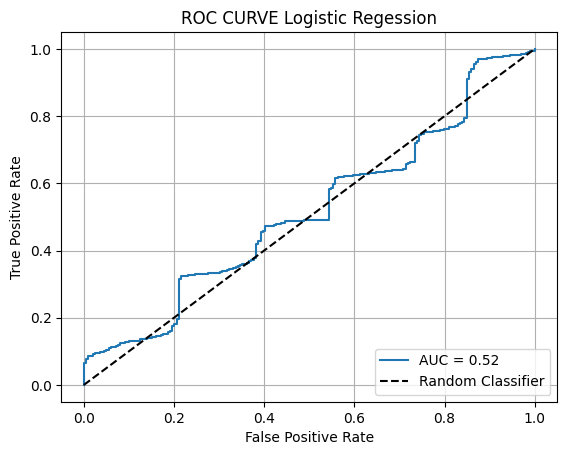

In [101]:
y_pred_proba = log_reg.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot (fpr,tpr,label=f"AUC = {round(auc, 2)}")
plt.plot([0, 1], [0, 1], '--k', label='Random Classifier')
plt.grid()
plt.title('ROC CURVE Logistic Regession')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show() 

Дерево решений

In [102]:
def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 100),
        'criterion': 'entropy',
    }
 
    d_tree = DecisionTreeClassifier(**params)
    d_tree.fit(X_train, y_train)
    
    preds = d_tree.predict_proba(X_val)[:, 1]
    roc_auc = roc_auc_score(y_val, preds)
    
    return roc_auc

study = optuna.create_study(study_name='Tree', direction='maximize')
study.optimize(objective, n_trials=50)

[I 2024-05-21 01:00:50,752] A new study created in memory with name: Tree
[I 2024-05-21 01:00:51,225] Trial 0 finished with value: 0.9465566629577898 and parameters: {'max_depth': 76}. Best is trial 0 with value: 0.9465566629577898.
[I 2024-05-21 01:00:51,676] Trial 1 finished with value: 0.9396400022095437 and parameters: {'max_depth': 45}. Best is trial 0 with value: 0.9465566629577898.
[I 2024-05-21 01:00:52,128] Trial 2 finished with value: 0.9415299511533028 and parameters: {'max_depth': 69}. Best is trial 0 with value: 0.9465566629577898.
[I 2024-05-21 01:00:52,602] Trial 3 finished with value: 0.9434120088697395 and parameters: {'max_depth': 87}. Best is trial 0 with value: 0.9465566629577898.
[I 2024-05-21 01:00:53,071] Trial 4 finished with value: 0.9377500532657844 and parameters: {'max_depth': 73}. Best is trial 0 with value: 0.9465566629577898.
[I 2024-05-21 01:00:53,528] Trial 5 finished with value: 0.937757944493107 and parameters: {'max_depth': 22}. Best is trial 0 with 

In [103]:
study.best_params

{'max_depth': 94}

In [104]:
d_tree = DecisionTreeClassifier(**study.best_params)
d_tree.fit(X_train, y_train)
predictions = d_tree.predict(X_test)
accuracy_array.append(accuracy_score(y_test, predictions))
accuracy_score(y_test, predictions)

0.9648829431438127

In [105]:
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
roc_auc = roc_auc_score(y_test, d_tree.predict_proba(X_test)[:, 1])
roc_auc_array.append(roc_auc)
precision_array.append(precision)
recall_array.append(recall)
print(f"Precision = {precision}")
print(f"Recall = {recall}")
print(f"roc_auc = {roc_auc}")

Precision = 0.9828109201213346
Recall = 0.9749247743229689
roc_auc = 0.9447488193222885


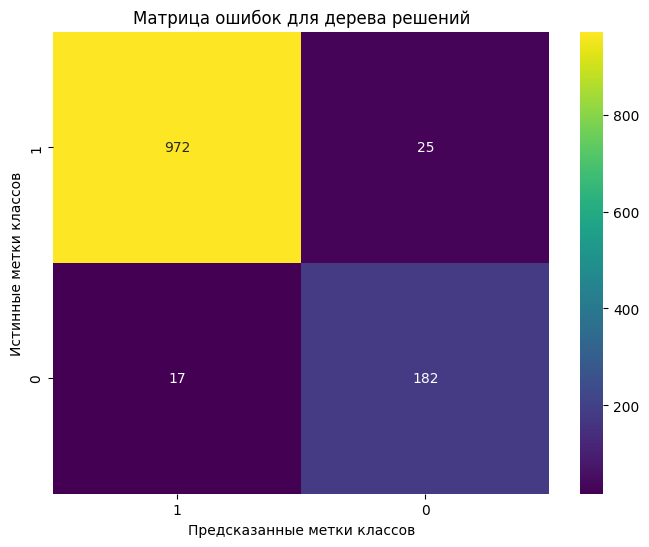

In [106]:
cm = confusion_matrix(y_test, predictions, labels=labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='viridis', cbar=True)
plt.xlabel('Предсказанные метки классов')
plt.ylabel('Истинные метки классов')
plt.title('Матрица ошибок для дерева решений')
plt.show()

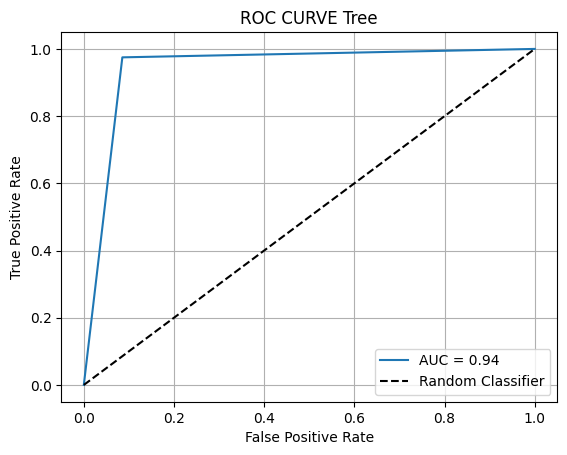

In [107]:
y_pred_proba = d_tree.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot (fpr,tpr,label=f"AUC = {round(auc, 2)}")
plt.plot([0, 1], [0, 1], '--k', label='Random Classifier')
plt.grid()
plt.title('ROC CURVE Tree')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show() 

Градиентный бустинг

In [108]:
def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 2),
        'num_leaves': trial.suggest_int('num_leaves', 35, 4095),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 100),
        'objective': 'binary',
        'random_state': 42,
        'verbose': -1
    }
 
    clf = LGBMClassifier(**params)
    clf.fit(X_train, y_train)
    
    preds = clf.predict_proba(X_val)[:, 1]
    roc_auc = roc_auc_score(y_val, preds)
    
    return roc_auc
    

In [109]:
study = optuna.create_study(direction='maximize', study_name='Boosting')
study.optimize(objective, n_trials=100)

[I 2024-05-21 01:01:14,976] A new study created in memory with name: Boosting
[I 2024-05-21 01:01:15,070] Trial 0 finished with value: 0.9994081579508061 and parameters: {'learning_rate': 0.3338748652209853, 'num_leaves': 42, 'reg_lambda': 0.089446376605959, 'reg_alpha': 0.15420103727031131, 'min_child_samples': 7}. Best is trial 0 with value: 0.9994081579508061.
[I 2024-05-21 01:01:15,280] Trial 1 finished with value: 0.9993923754961609 and parameters: {'learning_rate': 0.16215029663137787, 'num_leaves': 1340, 'reg_lambda': 0.6613265736745066, 'reg_alpha': 0.657082632373761, 'min_child_samples': 9}. Best is trial 0 with value: 0.9994081579508061.
[I 2024-05-21 01:01:15,449] Trial 2 finished with value: 0.9988478808109025 and parameters: {'learning_rate': 0.03442889165776234, 'num_leaves': 765, 'reg_lambda': 0.26401049096138574, 'reg_alpha': 0.30469326186569246, 'min_child_samples': 70}. Best is trial 0 with value: 0.9994081579508061.
[I 2024-05-21 01:01:15,513] Trial 3 finished with v

[I 2024-05-21 01:01:23,304] Trial 28 finished with value: 0.9998342842262257 and parameters: {'learning_rate': 0.18455312437382093, 'num_leaves': 1969, 'reg_lambda': 0.7135667005585677, 'reg_alpha': 0.06513058898643807, 'min_child_samples': 58}. Best is trial 23 with value: 0.9998895228174838.
[I 2024-05-21 01:01:24,027] Trial 29 finished with value: 0.9997790456349676 and parameters: {'learning_rate': 0.22112697790942754, 'num_leaves': 3999, 'reg_lambda': 0.8162830225867902, 'reg_alpha': 0.12398322663312274, 'min_child_samples': 58}. Best is trial 23 with value: 0.9998895228174838.
[I 2024-05-21 01:01:24,387] Trial 30 finished with value: 0.9997869368622901 and parameters: {'learning_rate': 0.2707394764864129, 'num_leaves': 2026, 'reg_lambda': 0.7297859096578017, 'reg_alpha': 0.0888785115624514, 'min_child_samples': 72}. Best is trial 23 with value: 0.9998895228174838.
[I 2024-05-21 01:01:24,919] Trial 31 finished with value: 0.9996922421344192 and parameters: {'learning_rate': 0.3545

[I 2024-05-21 01:01:38,895] Trial 56 finished with value: 0.9998185017715805 and parameters: {'learning_rate': 0.440564232831392, 'num_leaves': 3395, 'reg_lambda': 0.8779854059683833, 'reg_alpha': 0.042850290829496526, 'min_child_samples': 25}. Best is trial 23 with value: 0.9998895228174838.
[I 2024-05-21 01:01:39,384] Trial 57 finished with value: 0.9998106105442579 and parameters: {'learning_rate': 0.5689533121393837, 'num_leaves': 2444, 'reg_lambda': 0.924158915939455, 'reg_alpha': 0.0248903577087114, 'min_child_samples': 19}. Best is trial 23 with value: 0.9998895228174838.
[I 2024-05-21 01:01:39,778] Trial 58 finished with value: 0.9993608105868705 and parameters: {'learning_rate': 0.6315864034722152, 'num_leaves': 2141, 'reg_lambda': 0.7173204270255152, 'reg_alpha': 0.09138155842901644, 'min_child_samples': 29}. Best is trial 23 with value: 0.9998895228174838.
[I 2024-05-21 01:01:40,183] Trial 59 finished with value: 0.9997080245890644 and parameters: {'learning_rate': 0.4070943

[I 2024-05-21 01:01:57,688] Trial 84 finished with value: 0.9998106105442579 and parameters: {'learning_rate': 0.750044056380156, 'num_leaves': 3734, 'reg_lambda': 0.9067837441942973, 'reg_alpha': 0.02229526160752615, 'min_child_samples': 28}. Best is trial 64 with value: 0.9999605438633871.
[I 2024-05-21 01:01:58,349] Trial 85 finished with value: 0.9996370035431611 and parameters: {'learning_rate': 0.5914034450432503, 'num_leaves': 3598, 'reg_lambda': 0.927598127554192, 'reg_alpha': 0.11476069532772107, 'min_child_samples': 23}. Best is trial 64 with value: 0.9999605438633871.
[I 2024-05-21 01:01:58,825] Trial 86 finished with value: 0.9996054386338707 and parameters: {'learning_rate': 0.8240507461341637, 'num_leaves': 3097, 'reg_lambda': 0.8694378758912014, 'reg_alpha': 0.05930088393971185, 'min_child_samples': 33}. Best is trial 64 with value: 0.9999605438633871.
[I 2024-05-21 01:01:59,333] Trial 87 finished with value: 0.9997474807256773 and parameters: {'learning_rate': 0.6133613

In [110]:
study.best_params

{'learning_rate': 0.49766821500252745,
 'num_leaves': 3100,
 'reg_lambda': 0.7508608569519373,
 'reg_alpha': 0.030038710598006113,
 'min_child_samples': 35}

In [111]:
boosting_clf = LGBMClassifier(verbose=-1, **study.best_params)
boosting_clf.fit(X_train, y_train)
predictions = boosting_clf.predict(X_test)
accuracy_array.append(accuracy_score(y_test, predictions))
accuracy_score(y_test, predictions)

0.9891304347826086

In [112]:
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
roc_auc = roc_auc_score(y_test, boosting_clf.predict_proba(X_test)[:, 1])
roc_auc_array.append(roc_auc)
precision_array.append(precision)
recall_array.append(recall)
print(f"Precision = {precision}")
print(f"Recall = {recall}")
print(f"roc_auc = {roc_auc}")

Precision = 0.9871287128712871
Recall = 1.0
roc_auc = 0.9997177462034345


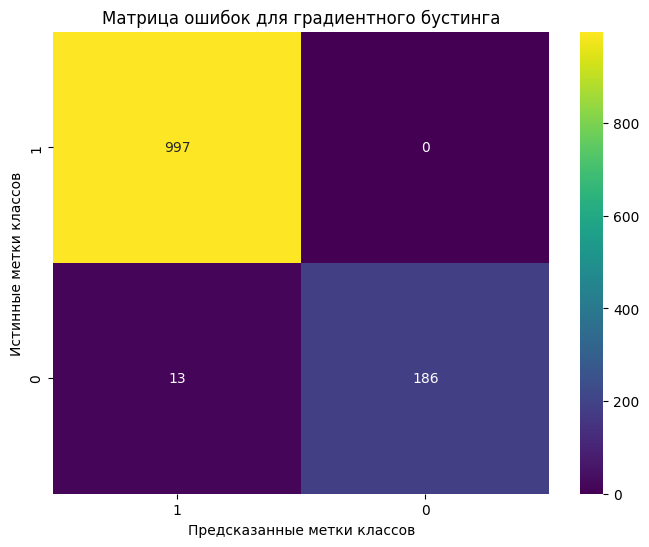

In [113]:
cm = confusion_matrix(y_test, predictions, labels=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='viridis', cbar=True)
plt.xlabel('Предсказанные метки классов')
plt.ylabel('Истинные метки классов')
plt.title('Матрица ошибок для градиентного бустинга')
plt.show()

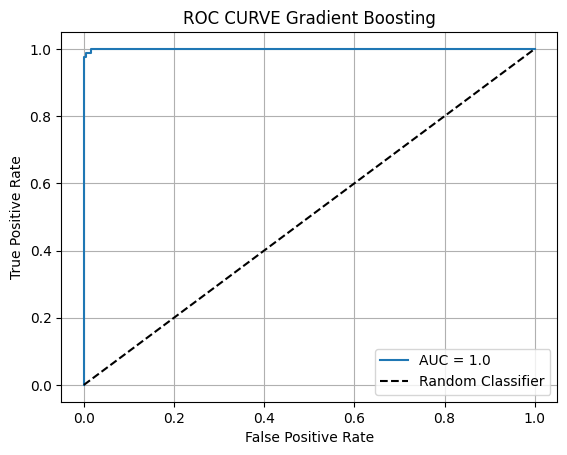

In [114]:
y_pred_proba = boosting_clf.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot (fpr,tpr,label=f"AUC = {round(auc, 3)}")
plt.plot([0, 1], [0, 1], '--k', label='Random Classifier')
plt.grid()
plt.title('ROC CURVE Gradient Boosting')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show() 

In [115]:
models_list = ['Логистическая регрессия', 'Дерево решений', 'Градиентный бустинг']
metrics = pd.DataFrame({'Модель': models_list,
                        'Accuracy': np.round(np.array(accuracy_array), 4),
                       'Precision': np.round(np.array(precision_array), 4),
                       'Recall': np.round(np.array(recall_array), 4),
                       'AUC ROC': np.round(np.array(roc_auc_array), 4)})
metrics.to_excel('Second_binary.xlsx')